In [1]:
import py4DSTEM
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from more_itertools import chunked, grouper
import tifffile
import os
from matplotlib.colors import LogNorm, CenteredNorm, SymLogNorm, PowerNorm
import cmasher as cm
import abtem
import h5py

from acBF_utils import*

py4DSTEM.__version__

cupyx.jit.rawkernel is experimental. The interface can change in the future.


'0.14.17'

In [2]:
savepath = "Figure 4/"
dataname = "scan_x128_y128.raw"
scan_step_size = 0.43
convergence_angle = 25  # mrad

In [3]:
dataset = py4DSTEM.import_file(savepath + dataname)

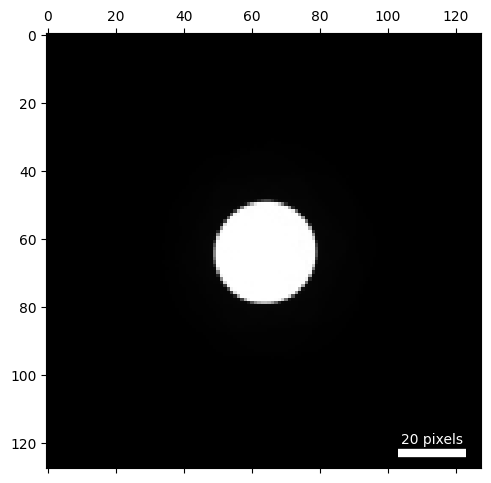

In [4]:
meanDP = dataset.get_dp_mean()
py4DSTEM.show(meanDP)

In [5]:
dataset.calibration

Calibration( A Metadata instance called 'calibration', containing the following fields:

             Q_pixel_size:    1
             R_pixel_size:    1
             Q_pixel_units:   pixels
             R_pixel_units:   pixels
             QR_flip:         False
)

Estimated probe radius = 14.93 pixels
Probe center is at 64.27,63.95


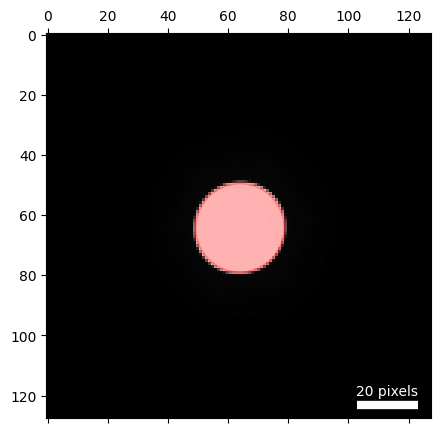

In [6]:
# Estimate the radius of the BF disk, and the center coordinates
probe_semiangle, probe_qx0, probe_qy0 = py4DSTEM.process.calibration.get_probe_size(
    dataset.tree("dp_mean").data,
    thresh_lower=0.2,
    thresh_upper=0.99,
)

# plot the mean diffraction pattern, with the estimated probe radius overlaid as a circle
py4DSTEM.visualize.show_circles(
    dataset.tree("dp_mean").data, (probe_qx0, probe_qy0), probe_semiangle
)

# Print the estimate probe radius
print("Estimated probe radius =", "%.2f" % probe_semiangle, "pixels")
print(f"Probe center is at {probe_qx0:.2f},{probe_qy0:.2f}")

In [7]:
dataset.calibration.set_R_pixel_size(scan_step_size)
dataset.calibration.set_R_pixel_units("A")
dataset.calibration.set_Q_pixel_size(convergence_angle/ probe_semiangle)
dataset.calibration.set_Q_pixel_units("mrad")

In [8]:
dataset.calibration

Calibration( A Metadata instance called 'calibration', containing the following fields:

             Q_pixel_size:    1.6741175786219609
             R_pixel_size:    0.43
             Q_pixel_units:   mrad
             R_pixel_units:   A
             QR_flip:         False
)

In [9]:
img_BF = dataset.get_virtual_image(
    mode="circle",
    geometry=((probe_qx0, probe_qy0), 1),
)

100%|██████████| 16384/16384 [00:00<00:00, 50278.78it/s]


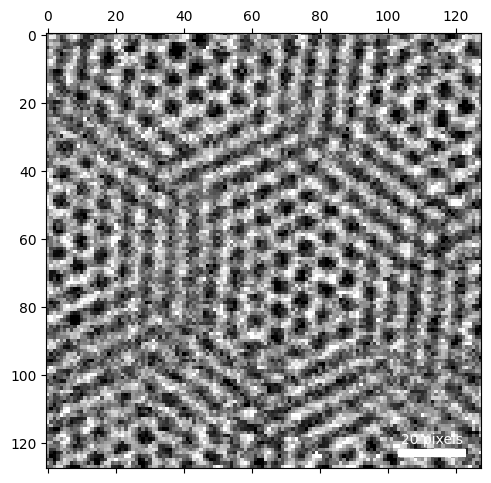

In [10]:
img_BF = img_BF.data
py4DSTEM.show(img_BF)

In [11]:
tcBF = py4DSTEM.process.phase.Parallax(
    energy=80e3,
    datacube=dataset,
    object_padding_px=(16,16),
)

Parallax( A Node called 'parallax_reconstruction', containing the following top-level objects in its tree:

)

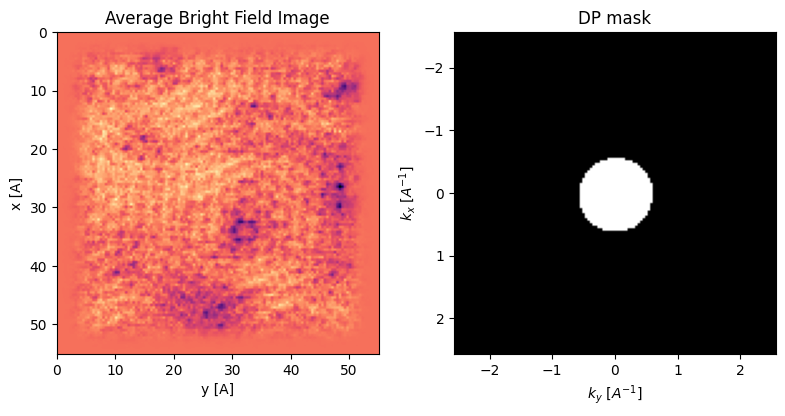

In [12]:
tcBF.preprocess(
    device = 'cpu',
)

Alignment at bin 4: 100%|██████████| 57/57 [00:00<00:00, 364.34 image subsets/s]


Parallax( A Node called 'parallax_reconstruction', containing the following top-level objects in its tree:

)

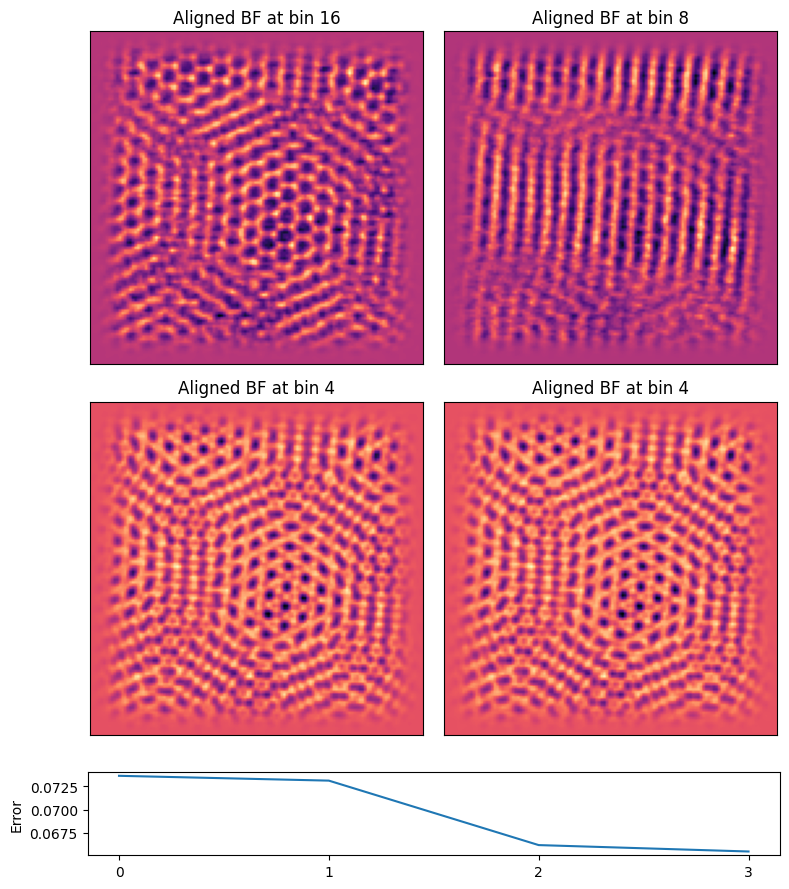

In [13]:
tcBF.reconstruct(
    # reset=True,
    # max_alignment_bin=8,
    # min_alignment_bin=2,
    # regularizer_matrix_size=(1, 1),
    # regularize_shifts=False,
    
    reset=True,
    regularizer_matrix_size=(2,2),
    regularize_shifts=False,
    running_average=True,
    min_alignment_bin = 4,
    num_iter_at_min_bin = 2,
    #max_iter_at_min_bin = 6,
)

Initial Aberration coefficients
-------------------------------
Rotation of Q w.r.t. R = -88.664 deg
Astigmatism (A1x,A1y)  = (4,3) Ang
Aberration C1          =  -107 Ang
Defocus dF             = 107 Ang
Transpose              = True

Refined Aberration coefficients
-------------------------------
aberration    radial   angular   dir.   coefs
name          order    order             Ang 
----------   -------   -------   ----   -----
C1              2        0         -      107
C3              4        0         -      353
stig            2        2         x      -4
stig            2        2         y      -3
coma            3        1         x      -66
coma            3        1         y      88
stig2           4        2         x      49
stig2           4        2         y      280


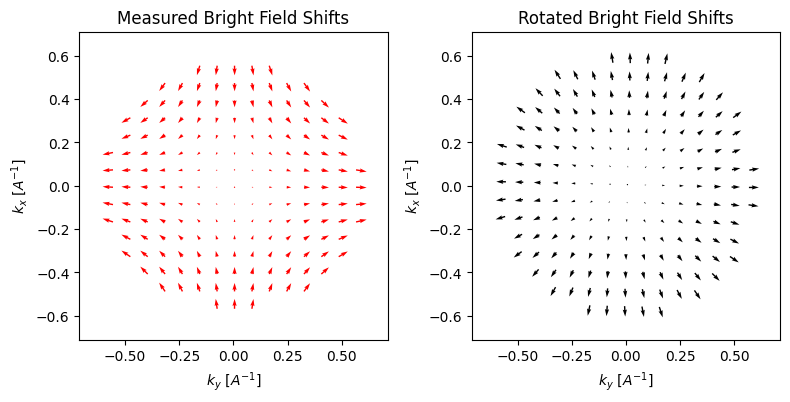

In [14]:
tcBF.aberration_fit(
    fit_BF_shifts=True,
    fit_aberrations_max_radial_order=4,
    fit_aberrations_max_angular_order=2,
    # plot_BF_shifts_comparison=True,
    # force_transpose=True,
    # force_rotation_deg=86,
    force_transpose=True,
)

tcBF.show_shifts(plot_arrow_freq=2, scale_arrows=0.2)
# tcBF.show_shifts()

In [15]:
tcBF.aberration_dict_polar

{'C10': 106.87749387106743,
 'C12': 4.98349684964397,
 'phi12': -1.275806003783948,
 'C21': 110.19191235314754,
 'phi21': 2.2132496640252954,
 'C30': 353.226854956342,
 'C32': 284.76324308597856,
 'phi32': 0.6984053864081364}

# CTF Correction

In [16]:
tcBF.aberration_dict_polar

{'C10': 106.87749387106743,
 'C12': 4.98349684964397,
 'phi12': -1.275806003783948,
 'C21': 110.19191235314754,
 'phi21': 2.2132496640252954,
 'C30': 353.226854956342,
 'C32': 284.76324308597856,
 'phi32': 0.6984053864081364}

<Axes: xlabel='alpha [mrad]', ylabel='Envelope'>

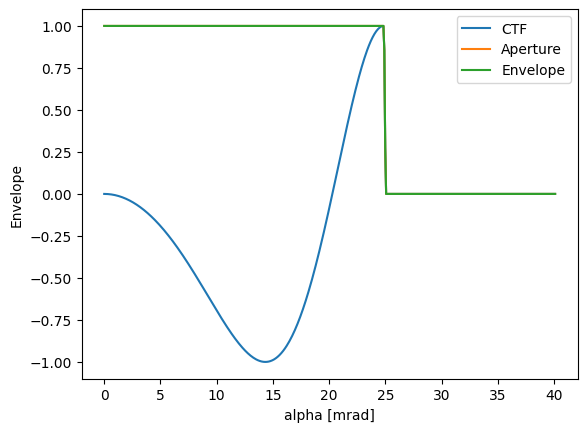

In [17]:
ctf = abtem.CTF(
    energy=80e3,
    **tcBF.aberration_dict_polar,
    semiangle_cutoff=25,
    rolloff=0.2,
)
ctf.show()

In [18]:
upscale = 2
tcBF_orig, tcBF_corr, acBF = acBF_STEM(tcBF, upscale, ctf)

100%|██████████| 679/679 [00:14<00:00, 45.47it/s]


# plots

In [19]:
R_pixel_size = tcBF._scan_sampling[0]
R_Nx = dataset.R_Nx

scan_size = R_pixel_size*R_Nx
scan_extent = (-scan_size / 2, scan_size / 2, -scan_size / 2, scan_size / 2)

recon_size = R_pixel_size * tcBF_corr.shape[0]/upscale
recon_extent = (-recon_size / 2, recon_size / 2, -recon_size / 2, recon_size / 2)

scan_qx = np.fft.fftfreq(R_Nx, R_pixel_size)
scan_fft_extent = (scan_qx.min(), scan_qx.max(), scan_qx.min(), scan_qx.max())

recon_qx = np.fft.fftfreq(tcBF_corr.shape[0], R_pixel_size/upscale)
recon_fft_extent = (recon_qx.min(), recon_qx.max(), recon_qx.min(), recon_qx.max())

acBF_qx = np.fft.fftfreq(tcBF_corr.shape[0], R_pixel_size/upscale)
acBF_fft_extent = (acBF_qx.min(), acBF_qx.max(), acBF_qx.min(), acBF_qx.max())


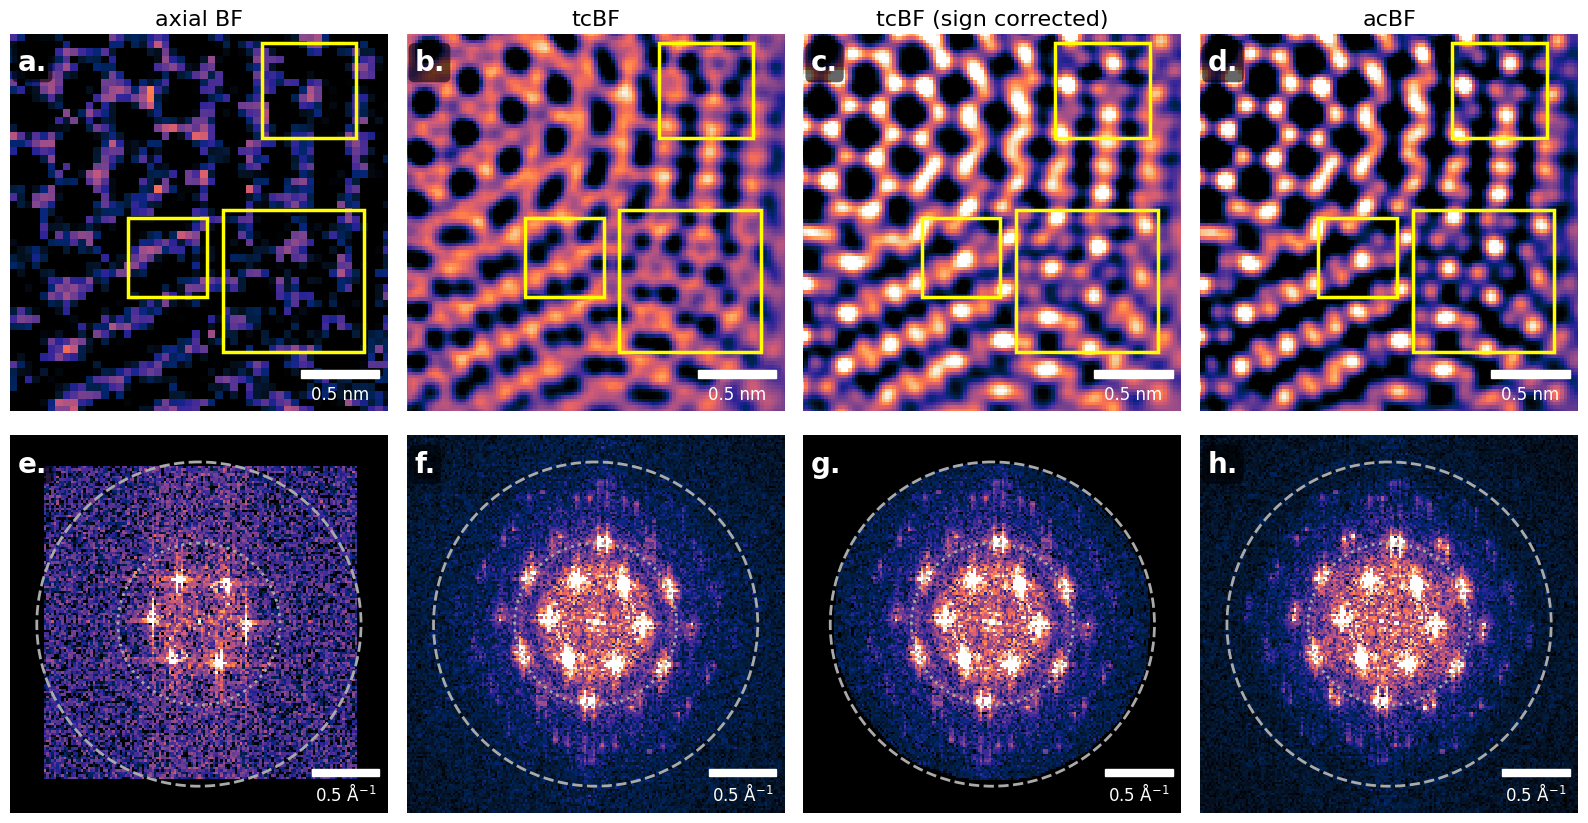

In [20]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import PowerNorm
from matplotlib.patches import Rectangle
from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar
from matplotlib import font_manager
import cmasher as cm

fig, ax = plt.subplots(2, 4, figsize=(16, 8))
"""
 ___ __  __    _    ____ _____ ____  
|_ _|  \/  |  / \  / ___| ____/ ___| 
 | || |\/| | / _ \| |  _|  _| \___ \ 
 | || |  | |/ ___ \ |_| | |___ ___) |
|___|_|  |_/_/   \_\____|_____|____/ 
"""
image_percentiles = (0.1, 99.3)
if ctf.C10 >0:
    bf_cmap = cm.torch_r
else:
    bf_cmap = cm.torch
recon_cmap = cm.torch

def normalize01(img):
    img = np.asarray(img)
    img_min = np.min(img)
    img_max = np.max(img)
    if img_max == img_min:
        return np.zeros_like(img)
    return (img - img_min) / (img_max - img_min)

ax[0, 0].matshow(
    normalize01(img_BF),
    extent=recon_extent,
    cmap=recon_cmap,
    vmin=0.4, vmax=0.99,
    #interpolation='bicubic',
)
ax[0, 1].xaxis.tick_bottom()

ax[0, 1].matshow(
    normalize01(tcBF_orig),
    extent=recon_extent,
    cmap=recon_cmap,
    vmin=0.4, vmax=0.999,
    #interpolation='bicubic',
)
ax[0, 1].xaxis.tick_bottom()

ax[0, 2].matshow(
    normalize01(tcBF_corr),
    extent=recon_extent,
    cmap=recon_cmap,
    vmin=0.2, vmax=0.75,
)
ax[0, 2].xaxis.tick_bottom()

ax[0, 3].matshow(
    normalize01(acBF),
    extent=recon_extent,
    cmap=recon_cmap,
    vmin=0.25, vmax=0.75,
)
ax[0, 3].xaxis.tick_bottom()

img_lim = 12
img_offset_x, img_offset_y = 13, -12
for j in range(4):
    ax[0, j].set_xlim(-img_lim + img_offset_x,  img_lim + img_offset_x)
    ax[0, j].set_ylim(-img_lim + img_offset_y,  img_lim + img_offset_y)

ax[0, 0].set_title("axial BF", fontsize=16)
ax[0, 1].set_title("tcBF", fontsize=16)
ax[0, 2].set_title("tcBF (sign corrected)", fontsize=16)
ax[0, 3].set_title("acBF", fontsize=16)

# ---------- HIGHLIGHT BOXES (real-space row) ----------
# Boxes are in the same data coordinates as each panel's extent.
from matplotlib.patches import Rectangle
# --- simple helper ---
def add_box(ax_i, x_offset, y_offset, size, color='white', lw=2.5, ls='-'):
    """
    Draw a square box of side 'size', centered at (x_offset, y_offset).
    """
    half = size / 2
    rect = Rectangle((x_offset - half, y_offset - half),
                     size, size,
                     fill=False,
                     edgecolor=color,
                     linewidth=lw,
                     linestyle=ls)
    ax_i.add_patch(rect)

for j in range(4):
    add_box(ax[0, j], 11, -14.24, 5, color = 'yellow')

# Second region
for j in range(4):
    add_box(ax[0, j], 20, -3.6, 6, color = 'yellow')

# Third region
for j in range(4):
    add_box(ax[0, j], 19, -15.7, 9, color = 'yellow')
# ------------------------------------------------------

"""
 _____ _____ _____    
|  ___|  ___|_   _|__ 
| |_  | |_    | |/ __|
|  _| |  _|   | |\__ \
|_|   |_|     |_||___/
"""
fft_percentiles = (10, 99.5)
fft_power = 0.5

# -----------------
# Row 1 (FFT space)
# -----------------
bf_fft = np.abs(np.fft.fftshift(np.fft.fft2(normalize01(img_BF))))
im0 = ax[1, 0].matshow(
    bf_fft,
    extent=scan_fft_extent,  # use scan FFT extent for BF
    norm=PowerNorm(gamma=fft_power,
                   vmin=np.percentile(bf_fft,  fft_percentiles[0]),
                   vmax=np.percentile(bf_fft,  fft_percentiles[1])),
    cmap=cm.torch,
)
# Force background of this panel to black
ax[1, 0].set_facecolor("black")

tcBF_fft = np.abs(np.fft.fftshift(np.fft.fft2(normalize01(tcBF_orig))))
ax[1, 1].matshow(
    tcBF_fft,
    extent=acBF_fft_extent,
    norm=PowerNorm(gamma=fft_power,
                   vmin=np.percentile(tcBF_fft, fft_percentiles[0]),
                   vmax=np.percentile(tcBF_fft, fft_percentiles[1])),
    cmap=cm.torch,
)

tcBF_ac_fft = np.abs(np.fft.fftshift(np.fft.fft2(normalize01(tcBF_corr))))
ax[1, 2].matshow(
    tcBF_ac_fft,
    extent=acBF_fft_extent,
    norm=PowerNorm(gamma=fft_power,
                   vmin=np.percentile(tcBF_ac_fft, fft_percentiles[0]),
                   vmax=np.percentile(tcBF_ac_fft, fft_percentiles[1])),
    cmap=cm.torch,
)

acBF_fft = np.abs(np.fft.fftshift(np.fft.fft2(normalize01(acBF))))
ax[1, 3].matshow(
    acBF_fft,
    extent=acBF_fft_extent,
    norm=PowerNorm(gamma=fft_power,
                   vmin=np.percentile(acBF_fft, fft_percentiles[0]),
                   vmax=np.percentile(acBF_fft, fft_percentiles[1])),
    cmap=cm.torch,
)


# Optional zoom for FFT panels (match your ranges)
for j in range(4):
    ax[1, j].set_xlim(-1.2/2 * recon_fft_extent[0], 1.2/2 * recon_fft_extent[0])
    ax[1, j].set_ylim(-1.2/2 * recon_fft_extent[0], 1.2/2 * recon_fft_extent[0])

"""
  ____ ___ ____   ____ _     _____ ____  
 / ___|_ _|  _ \ / ___| |   | ____/ ___| 
| |    | || |_) | |   | |   |  _| \___ \ 
| |___ | ||  _ <| |___| |___| |___ ___) |
 \____|___|_| \_\\____|_____|_____|____/ 
"""
# α and 2α circles on FFT panels
alpha_cutoff = ctf.semiangle_cutoff / ctf.wavelength / 1000.0
for a in ax[1]:
    a.add_artist(plt.Circle((0, 0), radius=alpha_cutoff,       color="#aaaaaa", linestyle=":",  fill=False, lw=2))
    a.add_artist(plt.Circle((0, 0), radius=2.0 * alpha_cutoff, color="#aaaaaa", linestyle="--", fill=False, lw=2))

# -----------------
# Replace ticks with SCALE BARS
# -----------------
sb_font = font_manager.FontProperties(size=12)

def add_scalebar(ax_i, size, label, size_vertical):
    sb = AnchoredSizeBar(ax_i.transData, size, label,
                         loc='lower right', pad=0.3, sep=5, borderpad=0.2,
                         frameon=False, color='white',
                         size_vertical=size_vertical,
                         fontproperties=sb_font)
    ax_i.add_artist(sb)

# Real-space bars (Å units) — here 1 nm = 10 Å
for j in range(4):
    add_scalebar(ax[0, j], size=5, label='0.5 nm', size_vertical=0.5)

# FFT-space bars (Å^{-1} units)
for j in range(4):
    add_scalebar(ax[1, j], size=0.5, label=r'0.5 Å$^{-1}$', size_vertical=0.05)

labels = ['a.', 'b.', 'c.', 'd.', 'e.', 'f.', 'g.', 'h.']
for row in range(2):
    for col in range(4):
        ax[row, col].text(
            0.02, 0.96, labels[row * 4 + col],  # position in axes coords
            transform=ax[row, col].transAxes,
            fontsize=20,
            fontweight='bold',
            color='white',
            va='top', ha='left',
            bbox=dict(facecolor='black', alpha=0.6,
                      boxstyle='round,pad=0.2', edgecolor='none')
        )


# Remove ticks/labels/spines everywhere (keep titles)
for row in ax:
    for a in row:
        a.set_xticks([]); a.set_yticks([])
        a.set_xlabel(""); a.set_ylabel("")
        for spine in a.spines.values():
            spine.set_visible(False)

# --- Force black background for subplot e (ax[1,0]) even with axis('off') ---
from matplotlib.patches import Rectangle

ax_e = ax[1, 0]
ax_e.add_artist(
    Rectangle(
        (0, 0), 1, 1,
        transform=ax_e.transAxes,   # fill the entire axes (0..1 x 0..1)
        facecolor='black',
        edgecolor='none',
        zorder=-100,                # behind the image
        clip_on=False
    )
)


# plt.subplots_adjust(left=0.05, right=0.95, top=0.95, bottom=0.05,
#                     wspace=0.05, hspace=0.05)
plt.subplots_adjust(left=0.01, right=0.99, top=0.99, bottom=0.01, wspace=0.05, hspace=0.05)
                    
# fig.savefig(savepath + "phason_compare.svg", dpi=300, bbox_inches="tight")
# fig.savefig(savepath + "phason_compare.pdf", dpi=600, bbox_inches="tight")
plt.show()
